### Imports

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import math 
import os 

### Visualization Functions

In [2]:
# Function to save and plot SIRV proportions
def saveAndPlotSIRVProportions(S, I_var, R, X, population, I, T, output_folder):
    # Load county names from the inputData folder
    county_names_path = os.path.join("inputData", "floridaCountyNames.csv")
    county_names_df = pd.read_csv(county_names_path)
    county_names = county_names_df["County"].tolist()

    # Collect SIRV proportions data
    sirvData = []
    for i in I:
        for t in T:
            total_population = population[i]
            s_prop = S[i, t].x / total_population if total_population > 0 else 0
            i_prop = I_var[i, t].x / total_population if total_population > 0 else 0
            r_prop = R[i, t].x / total_population if total_population > 0 else 0
            x_prop = X[i, t].x / total_population if total_population > 0 else 0
            sirvData.append([i, t, s_prop, i_prop, r_prop, x_prop])
    
    sirvDf = pd.DataFrame(sirvData, columns=["region", "timePeriod", "S_proportion", "I_proportion", "R_proportion", "X_proportion"])
    sirv_csv_path = os.path.join(output_folder, "sirvProportions.csv")
    sirvDf.to_csv(sirv_csv_path, index=False)
    print(f"SIRV proportions data saved to '{sirv_csv_path}'")

    numRegions = len(I)
    rows = 23
    cols = math.ceil(numRegions / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("SIRV Proportions Over Time for Each County", fontsize=16, y=0.95) 
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    for idx, i in enumerate(I):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        regionData = sirvDf[sirvDf["region"] == i]
        county_name = county_names[i - 1] if i - 1 < len(county_names) else f"Region {i}"
        ax.plot(regionData["timePeriod"], regionData["S_proportion"], label="S", color="blue")
        ax.plot(regionData["timePeriod"], regionData["I_proportion"], label="I", color="red")
        ax.plot(regionData["timePeriod"], regionData["R_proportion"], label="R", color="green")
        ax.plot(regionData["timePeriod"], regionData["X_proportion"], label="V", color="orange")
        ax.set_title(county_name, fontsize=10)
        ax.grid(True)
        
        # Add legend to each subplot
        ax.legend(loc="upper right", fontsize=6)

        if row == rows - 1:
            ax.set_xlabel("Time Period")
        if col == 0:
            ax.set_ylabel("Proportion")

    plot_path = os.path.join(output_folder, "sirvProportions.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"SIRV proportions plot saved to '{plot_path}'")
    plt.show()

# Function to save all decision variables to CSV files
def saveDecisionVariables(Z, A, S, I_var, R, X, u, v, output_folder, T, T_prime, I, J):
    # Save travel data
    travelData = []
    for i in I:
        for j in J:
            for tPrime in T_prime:
                quantity = Z[i, j, tPrime].x
                if quantity > 0:
                    travelData.append([i, j, tPrime, quantity])
    travel_csv_path = os.path.join(output_folder, "travelData.csv")
    travelDf = pd.DataFrame(travelData, columns=["fromRegion", "toFacility", "timePeriod", "quantity"])
    travelDf.to_csv(travel_csv_path, index=False)
    print(f"Travel data saved to '{travel_csv_path}'")

    # Save vaccine allocation data
    vaccineAllocationData = []
    for i in I:
        for tPrime in T_prime:
            quantity = A[i, tPrime].x
            if quantity > 0:
                vaccineAllocationData.append([i, tPrime, quantity])
    vaccine_csv_path = os.path.join(output_folder, "vaccineAllocationData.csv")
    vaccineAllocationDf = pd.DataFrame(vaccineAllocationData, columns=["region", "timePeriod", "allocatedVaccines"])
    vaccineAllocationDf.to_csv(vaccine_csv_path, index=False)
    print(f"Vaccine allocation data saved to '{vaccine_csv_path}'")

    # Save SIRV data to CSV files
    save_variable_to_csv(S, "S", "susceptibleData.csv", output_folder, I, T)
    save_variable_to_csv(I_var, "I", "infectedData.csv", output_folder, I, T)
    save_variable_to_csv(R, "R", "recoveredData.csv", output_folder, I, T)
    save_variable_to_csv(X, "X", "vaccinatedData.csv", output_folder, I, T)
    save_variable_to_csv(u, "u", "unmetDemandData.csv", output_folder, I, T_prime)
    save_variable_to_csv(v, "v", "vaccinationsAdministeredData.csv", output_folder, I, T)

# Helper function to save each variable to CSV
def save_variable_to_csv(var, var_name, file_name, output_folder, I, time_period):
    data = []
    for i in I:
        for t in time_period:
            data.append([i, t, var[i, t].x])
    df = pd.DataFrame(data, columns=["region", "timePeriod", var_name])
    path = os.path.join(output_folder, file_name)
    df.to_csv(path, index=False)
    print(f"{var_name} data saved to '{path}'")

# Function to plot unmet demand
def plot_unmet_demand(u, T_prime, I):
    unmet_demand = [sum(u[i, t_prime].x for i in I) for t_prime in T_prime]
    plt.figure(figsize=(10, 6))
    plt.plot(T_prime, unmet_demand, marker='o', linestyle='-', color='b')
    plt.title("Total Unmet Healthcare Demand Over Time")
    plt.xlabel("Time Period (weeks)")
    plt.ylabel("Total Unmet Demand (individuals)")
    plt.grid(True)
    plt.xticks(T_prime)
    plt.show()

# Function to plot vaccine allocation
def plot_vaccine_allocation(vaccineAllocationDf, I, T_prime, output_folder):
    numRegions = len(I)
    rows = 23
    cols = math.ceil(numRegions / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("Vaccine Allocation Over Time for Each County", fontsize=16, y=0.95)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    for idx, i in enumerate(I):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        county_data = vaccineAllocationDf[vaccineAllocationDf["region"] == i]
        ax.plot(county_data["timePeriod"], county_data["allocatedVaccines"], color="purple")
        ax.set_title(f"County {i}", fontsize=10)
        ax.grid(True)

        if row == rows - 1:
            ax.set_xlabel("Time Period")
        if col == 0:
            ax.set_ylabel("Allocated Vaccines")

    plot_path = os.path.join(output_folder, "vaccineAllocation.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"Vaccine allocation plot saved to '{plot_path}'")
    plt.show()




### Run the Model (Travel Constraints Not Working)

In [3]:

# Load data files
distanceDF = pd.read_csv("inputData/Sorted_Distance.csv", header=None)   # Distance between counties
capacityDF = pd.read_csv("inputData/Capacity.csv", header=None)   # Healthcare facility capacities
populationDF = pd.read_csv("inputData/Population.csv", header=None)  # Population per county

# Define model parameters
t_B = 0                # Start time period
t_E = 26               # End time period (26 weeks)
psi = 1                # Decision interval
numCounties = 67       # Number of counties in Florida

# Define sets for counties, healthcare facilities, time periods, and decision periods
I = range(1, numCounties + 1)  # Set of regions (counties)
J = range(1, numCounties + 1)  # Set of healthcare facilities
T = range(t_B, t_E + 1)        # Set of time periods
T_prime = range(t_B, t_E + 1, psi)  # Set of decision-making time periods

# Model parameters
beta = {i: 0.3 for i in I}            # Infection rate
gamma = {i: 0.85 for i in I}           # Recovery rate
l = {i: 0.1 for i in I}               # Leaky vaccine probability
rho = {i: 0.1 for i in I}             # Hospitalization rate
C = {i: capacityDF.iloc[i-1, 0] for i in I}  # Capacity at each facility
V_total = {t: 20000 for t in T_prime}   # Total vaccines available per decision period
d = {(i, j): distanceDF.iloc[i-1, j-1] for i in I for j in J}  # Distance between counties
D_max = 150                            # Max travel distance
M = 1e6                                # Large constant for linear constraints

# Population and initial values
N = {i: populationDF.iloc[i-1, 0] for i in I}
S_initial = {i: 0.99 * N[i] for i in I}
I_initial = {i: 0.01 * N[i] for i in I}
R_initial = {i: 0.00 * N[i] for i in I}
X_initial = {i: 0.00 * N[i] for i in I}  # Initial vaccinated count

# Initialize Gurobi model
model = gp.Model("SIRV_Model")

# Define decision variables
u = model.addVars(I, T_prime, lb=0, name="u")          # Unmet demand
S = model.addVars(I, T, lb=0, name="S")                # Susceptible
I_var = model.addVars(I, T, lb=0, name="I")            # Infected
R = model.addVars(I, T, lb=0, name="R")                # Recovered
X = model.addVars(I, T, lb=0, name="X")                # Vaccinated
v = model.addVars(I, T, lb=0, name="v")                # Vaccinations administered
Z = model.addVars(I, J, T_prime, lb=0, name="Z")       # Patients transferred
x = model.addVars(I, T_prime, lb=0, name="x")          # Satisfied demand
A = model.addVars(I, T_prime, lb=0, name="A")          # Vaccines allocated
B = model.addVars(I, J, T_prime, vtype=GRB.BINARY, name="B")  # Binary transfer variable
W_SI = model.addVars(I, T, lb=0, name="W_SI")          # Auxiliary for linearizing S*I
Y_XI = model.addVars(I, T, lb=0, name="Y_XI")          # Auxiliary for linearizing X*I

# Objective function
model.setObjective(
    (1 / numCounties) * gp.quicksum(u[i, t_prime] for i in I for t_prime in T_prime) + 
    (1 / (numCounties * (numCounties - 1))) * gp.quicksum(Z[i, j, t_prime] for i in I for j in J if i != j for t_prime in T_prime), 
    GRB.MINIMIZE
)

# Constraints
for i in I:
    for t_prime in T_prime:
        # Constraint for satisfied and unmet demand
        model.addConstr(
            x[i, t_prime] + u[i, t_prime] == 
            sum(rho[i] * I_var[i, t] for t in range(t_B, t_prime+1, psi)) + 
            sum(Z[j, i, t_prime] for j in J if j != i) - sum(Z[i, j, t_prime] for j in J if j != i)
        )

        # Capacity constraint
        model.addConstr(x[i, t_prime] <= C[i] / gamma[i])

        # Vaccine allocation constraint
        model.addConstr(gp.quicksum(A[i, t_prime] for i in I) <= V_total[t_prime])

    for t in T:
        # Initial conditions
        if t == t_B:
            model.addConstr(S[i, t] == S_initial[i])
            model.addConstr(I_var[i, t] == I_initial[i])
            model.addConstr(R[i, t] == R_initial[i])
            model.addConstr(X[i, t] == X_initial[i])
        else:
            # Susceptible population with leaky vaccine
            model.addConstr(S[i, t] == S[i, t-1] - (beta[i] * W_SI[i, t-1] / N[i]) - v[i, t-1])

            # Infected population with leaky vaccine
            model.addConstr(I_var[i, t] == I_var[i, t-1] + (beta[i] * W_SI[i, t-1] / N[i]) + l[i] * beta[i] * Y_XI[i, t-1] / N[i] - gamma[i] * I_var[i, t-1])

            # Recovered population
            model.addConstr(R[i, t] == R[i, t-1] + gamma[i] * I_var[i, t-1])

            # Vaccinated population with leaky vaccine
            model.addConstr(X[i, t] == X[i, t-1] + v[i, t-1] - l[i] * beta[i] * Y_XI[i, t-1] / N[i])

            # Vaccination administered constraint
            model.addConstr(v[i, t] <= S[i, t])

    # Transfer constraints
    for j in J:
        for t_prime in T_prime:
            model.addConstr(Z[i, j, t_prime] <= M * B[i, j, t_prime])
            model.addConstr(d[i, j] * B[i, j, t_prime] <= D_max)
            model.addConstr(Z[i, j, t_prime] >= 0)

    # McCormick linearization constraints for W_SI (S * I) and Y_XI (X * I)
    for t in T:
        # Linearizing S[i, t] * I[i, t] with W_SI
        model.addConstr(W_SI[i, t] >= 0)
        model.addConstr(W_SI[i, t] >= N[i] * I_var[i, t] + N[i] * S[i, t] - N[i] ** 2)
        model.addConstr(W_SI[i, t] <= N[i] * S[i, t])
        model.addConstr(W_SI[i, t] <= N[i] * I_var[i, t])

        # Linearizing X[i, t] * I[i, t] with Y_XI
        model.addConstr(Y_XI[i, t] >= 0)
        model.addConstr(Y_XI[i, t] >= N[i] * I_var[i, t] + N[i] * X[i, t] - N[i] ** 2)
        model.addConstr(Y_XI[i, t] <= N[i] * X[i, t])
        model.addConstr(Y_XI[i, t] <= N[i] * I_var[i, t])

# Optimize the model
model.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 392486 rows, 260496 columns and 932573 nonzeros
Model fingerprint: 0xccd257ba
Variable types: 139293 continuous, 121203 integer (121203 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+06]
  Objective range  [2e-04, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+06]
Presolve removed 374290 rows and 208639 columns
Presolve time: 0.14s
Presolved: 18196 rows, 51857 columns, 147200 nonzeros
Variable types: 51857 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: obje

### Plot and Save Results

Travel data saved to 'outputData\travelData.csv'
Vaccine allocation data saved to 'outputData\vaccineAllocationData.csv'
S data saved to 'outputData\susceptibleData.csv'
I data saved to 'outputData\infectedData.csv'
R data saved to 'outputData\recoveredData.csv'
X data saved to 'outputData\vaccinatedData.csv'
u data saved to 'outputData\unmetDemandData.csv'
v data saved to 'outputData\vaccinationsAdministeredData.csv'


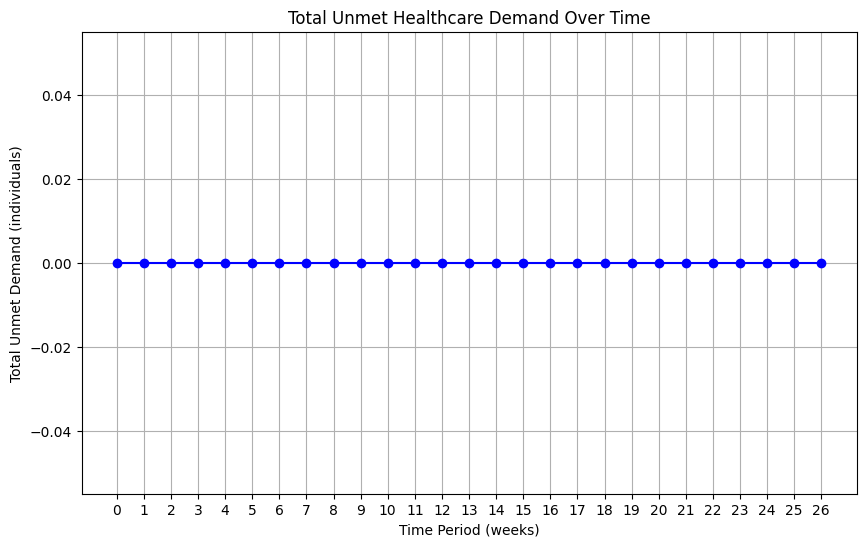

Vaccine allocation plot saved to 'outputData\vaccineAllocation.png'


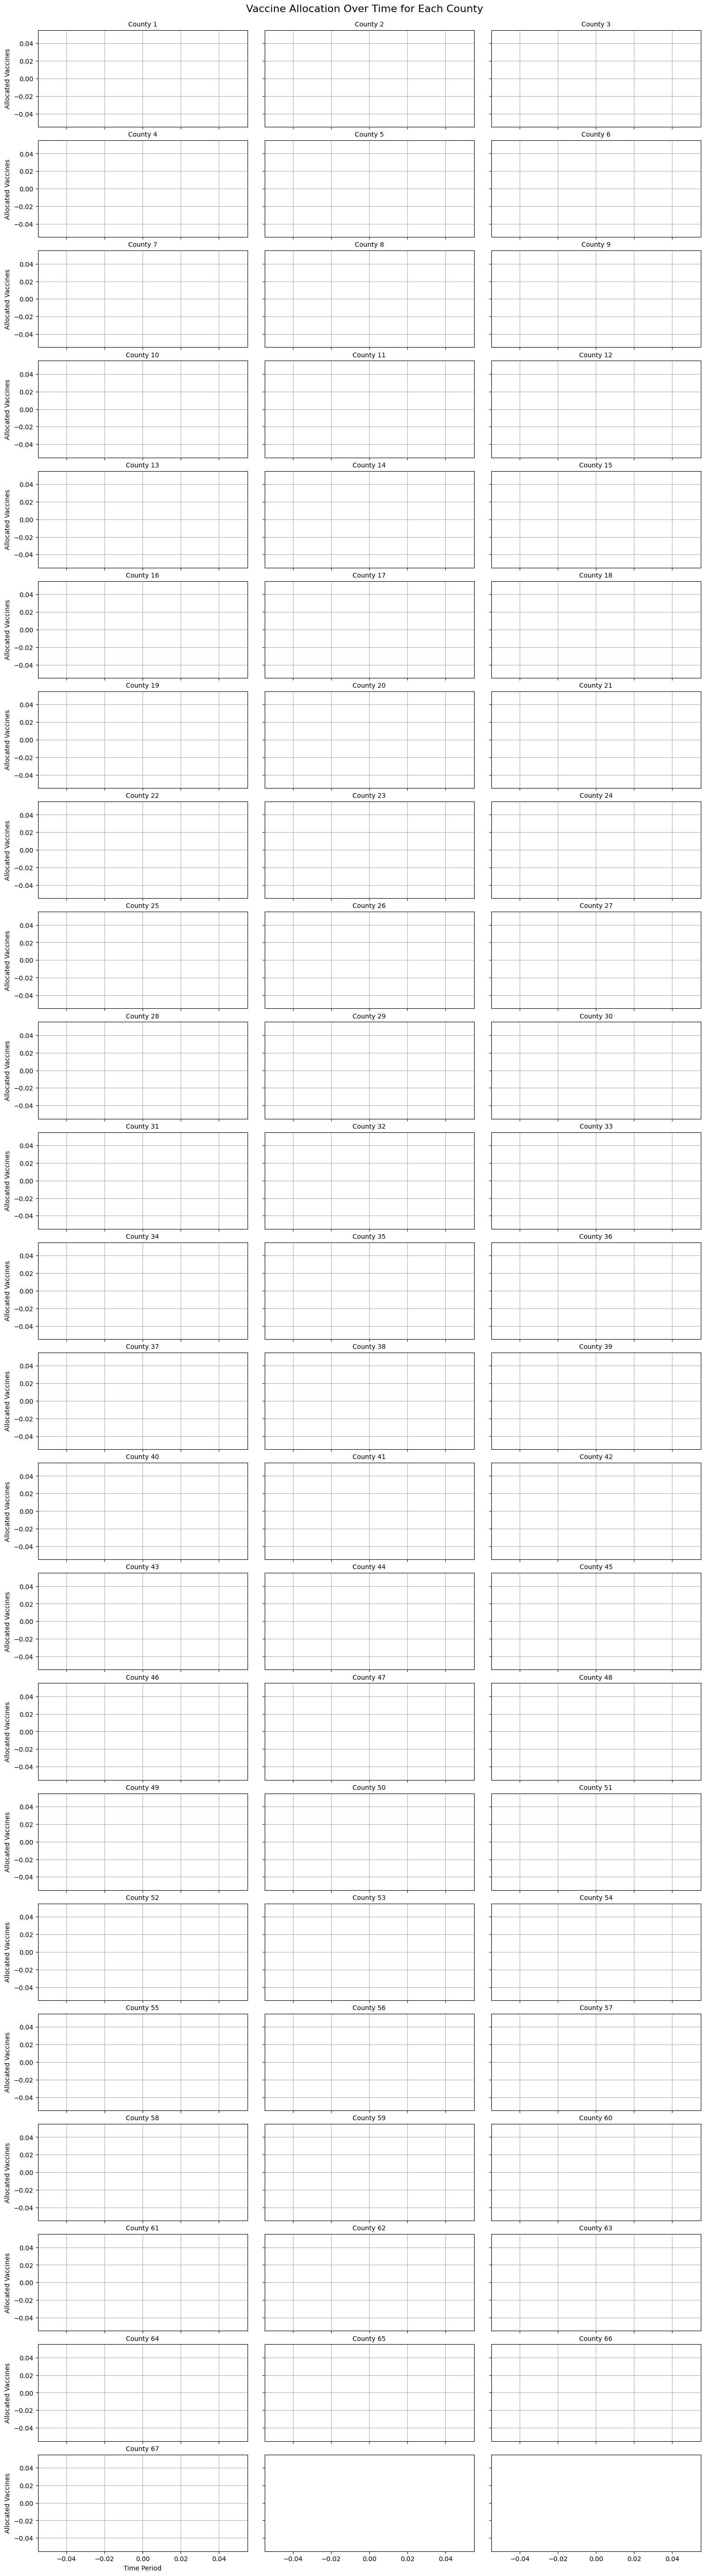

SIRV proportions data saved to 'outputData\sirvProportions.csv'
SIRV proportions plot saved to 'outputData\sirvProportions.png'


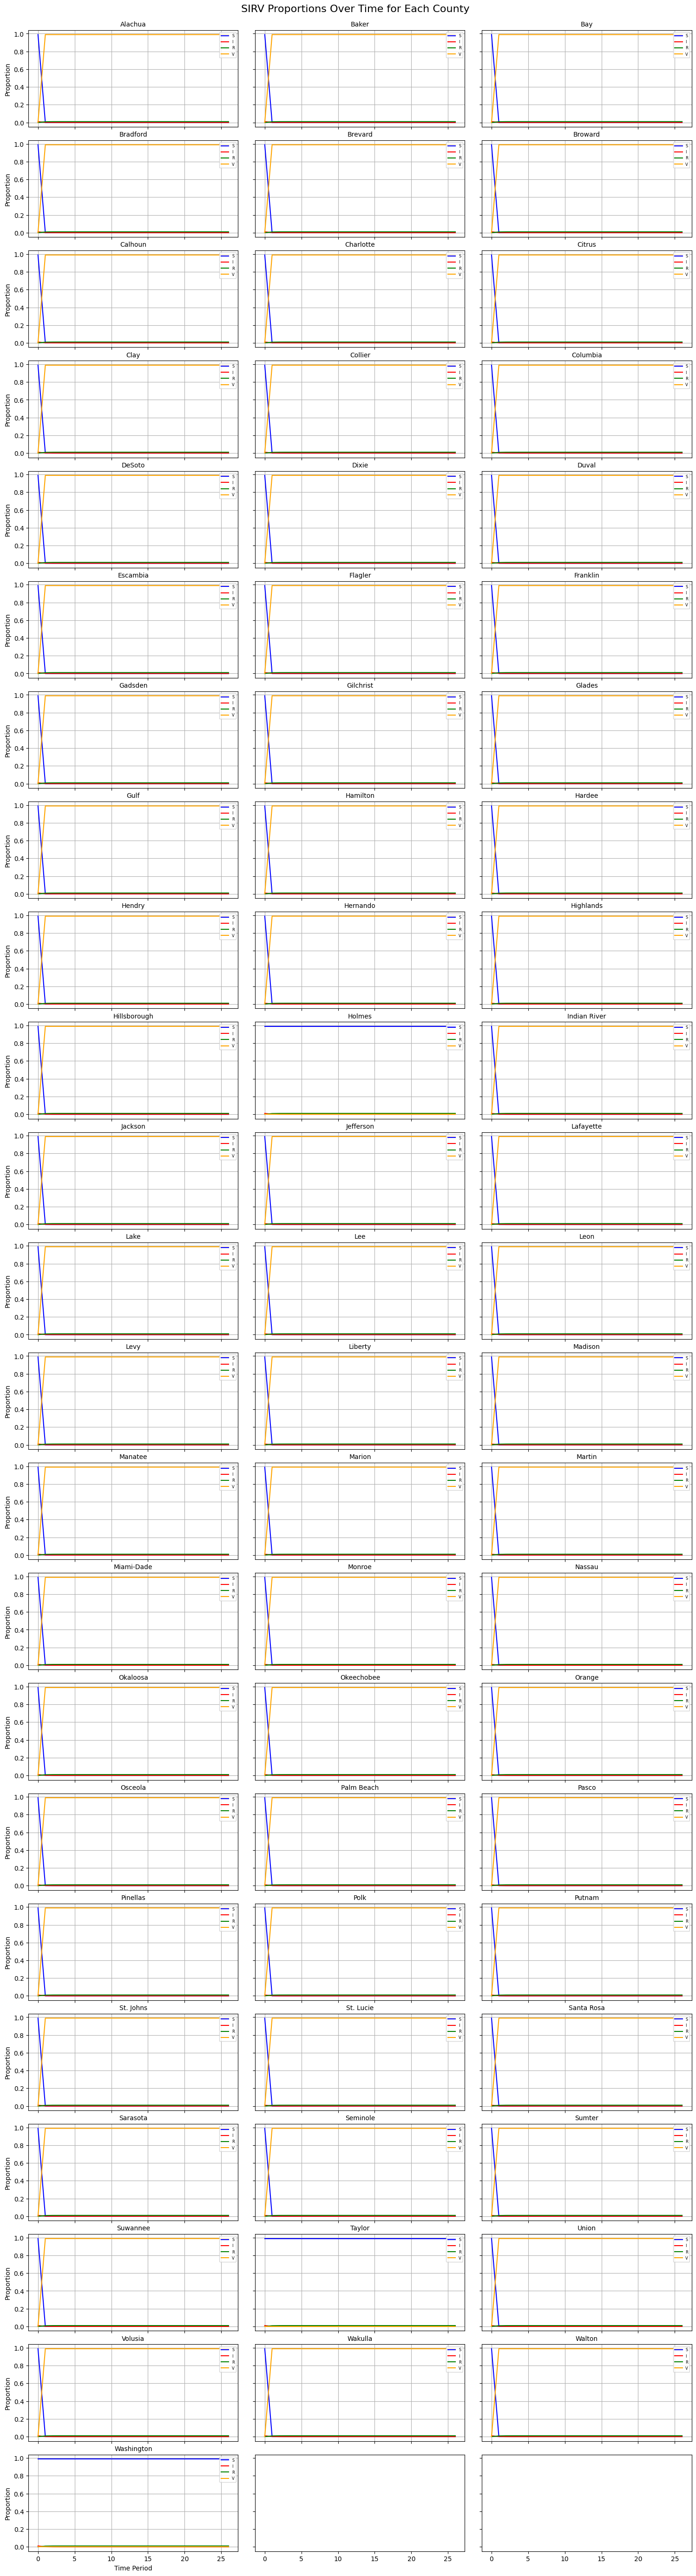

In [4]:
# Ensure the output folder exists
output_folder = "outputData"
os.makedirs(output_folder, exist_ok=True)

# Usage after model optimization
if model.status == GRB.OPTIMAL:
    saveDecisionVariables(Z, A, S, I_var, R, X, u, v, output_folder, T, T_prime, I, J) 
    plot_unmet_demand(u, T_prime, I)
    vaccineAllocationDf = pd.read_csv(os.path.join(output_folder, "vaccineAllocationData.csv"))
    plot_vaccine_allocation(vaccineAllocationDf, I, T_prime, output_folder)
    saveAndPlotSIRVProportions(S, I_var, R, X, N, I, T, output_folder)
else:
    print("bad")